## Data Loading

In [49]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import os

In [50]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS =20

In [51]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'rice_leaf_disease_images',
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 7926 files belonging to 5 classes.


In [52]:
class_names = dataset.class_names
class_names

['Bacterialblight', 'Blast', 'Brownspot', 'Healthy', 'Tungro']

In [53]:
len(dataset)

248

In [54]:
# One random batch of images
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[2 0 4 3 1 1 4 0 2 3 4 4 4 0 4 2 0 3 0 0 0 1 3 3 0 2 1 3 0 2 2 1]


(32, 256, 256, 3)
[1 2 2 0 0 4 4 2 3 0 1 0 2 2 0 1 0 4 0 0 3 3 2 3 3 1 3 1 1 2 4 1]


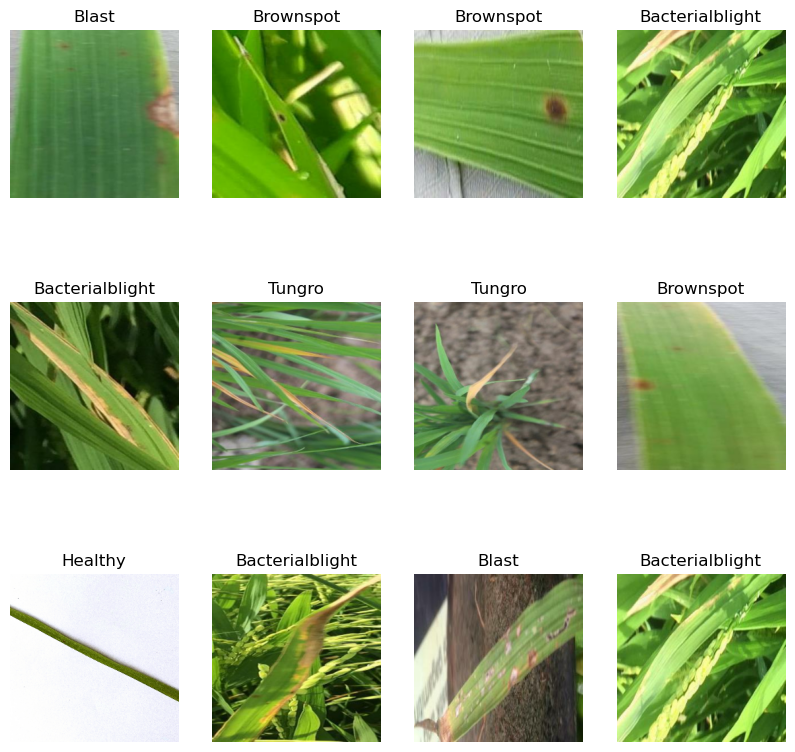

In [55]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    for i in range(12): #showing 12 images out of 32
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [56]:
# (32=batch_size, 256, 256=image_size, 0 to 3=typesofdiseases)
# 0 - Bacterial Blight
# 1 - Blast
# 2 - Brownspot
# 3 - Tungro

In [57]:
# Spitting dataset for training, validation and testing
# 80% for training 10% for validation and 10% for testing
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [58]:
train_ds, val_ds, test_ds =get_dataset_partitions_tf(dataset)

In [59]:
# Catching and prefeching
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

## Preprocessing

In [12]:
# Layer for resizing and rescaling
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [13]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

## Convolution Neural Network

In [14]:
#input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes= 5

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    
    layers.Conv2D(32,(3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64,kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64,kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64,kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64,kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64,kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

In [15]:
model.build(input_shape = input_shape)

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [17]:
model.compile(
    optimizer='adam', 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
    metrics=['accuracy'])

In [18]:
logdir='logs'

In [19]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [20]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=0,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

In [21]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds,
    callbacks=tensorboard_callback
)

Epoch 1/20
198/198 [==============================] - 534s 2s/step - loss: 1.0929 - accuracy: 0.5348 - val_loss: 0.8955 - val_accuracy: 0.6484
Epoch 2/20
198/198 [==============================] - 382s 2s/step - loss: 0.8101 - accuracy: 0.6821 - val_loss: 0.7629 - val_accuracy: 0.6940
Epoch 3/20
198/198 [==============================] - 338s 2s/step - loss: 0.6644 - accuracy: 0.7510 - val_loss: 0.6418 - val_accuracy: 0.7604
Epoch 4/20
198/198 [==============================] - 340s 2s/step - loss: 0.5215 - accuracy: 0.8037 - val_loss: 0.4311 - val_accuracy: 0.8464
Epoch 5/20
198/198 [==============================] - 332s 2s/step - loss: 0.4603 - accuracy: 0.8305 - val_loss: 0.3430 - val_accuracy: 0.8841
Epoch 6/20
198/198 [==============================] - 345s 2s/step - loss: 0.3659 - accuracy: 0.8633 - val_loss: 0.3713 - val_accuracy: 0.8503
Epoch 7/20
198/198 [==============================] - 349s 2s/step - loss: 0.3200 - accuracy: 0.8825 - val_loss: 0.4407 - val_accuracy: 0.8659

In [22]:
scores = model.evaluate(test_ds)
scores

26/26 [==============================] - 461s 2s/step - loss: 0.1224 - accuracy: 0.9519


[0.12244930863380432, 0.9519230723381042]

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

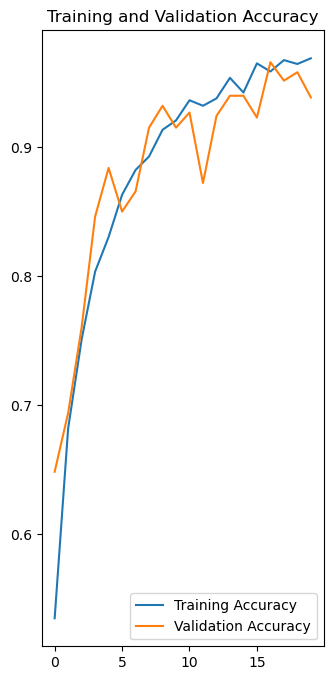

In [24]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

In [25]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    prediction = model.predict(img_array)
    
    prediction_class = class_names[np.argmax(prediction[0])]
    confidence = round(100 * (np.max(prediction[0])),2)
    
    return prediction_class, confidence

1/1 [==============================] - 1s 619ms/step


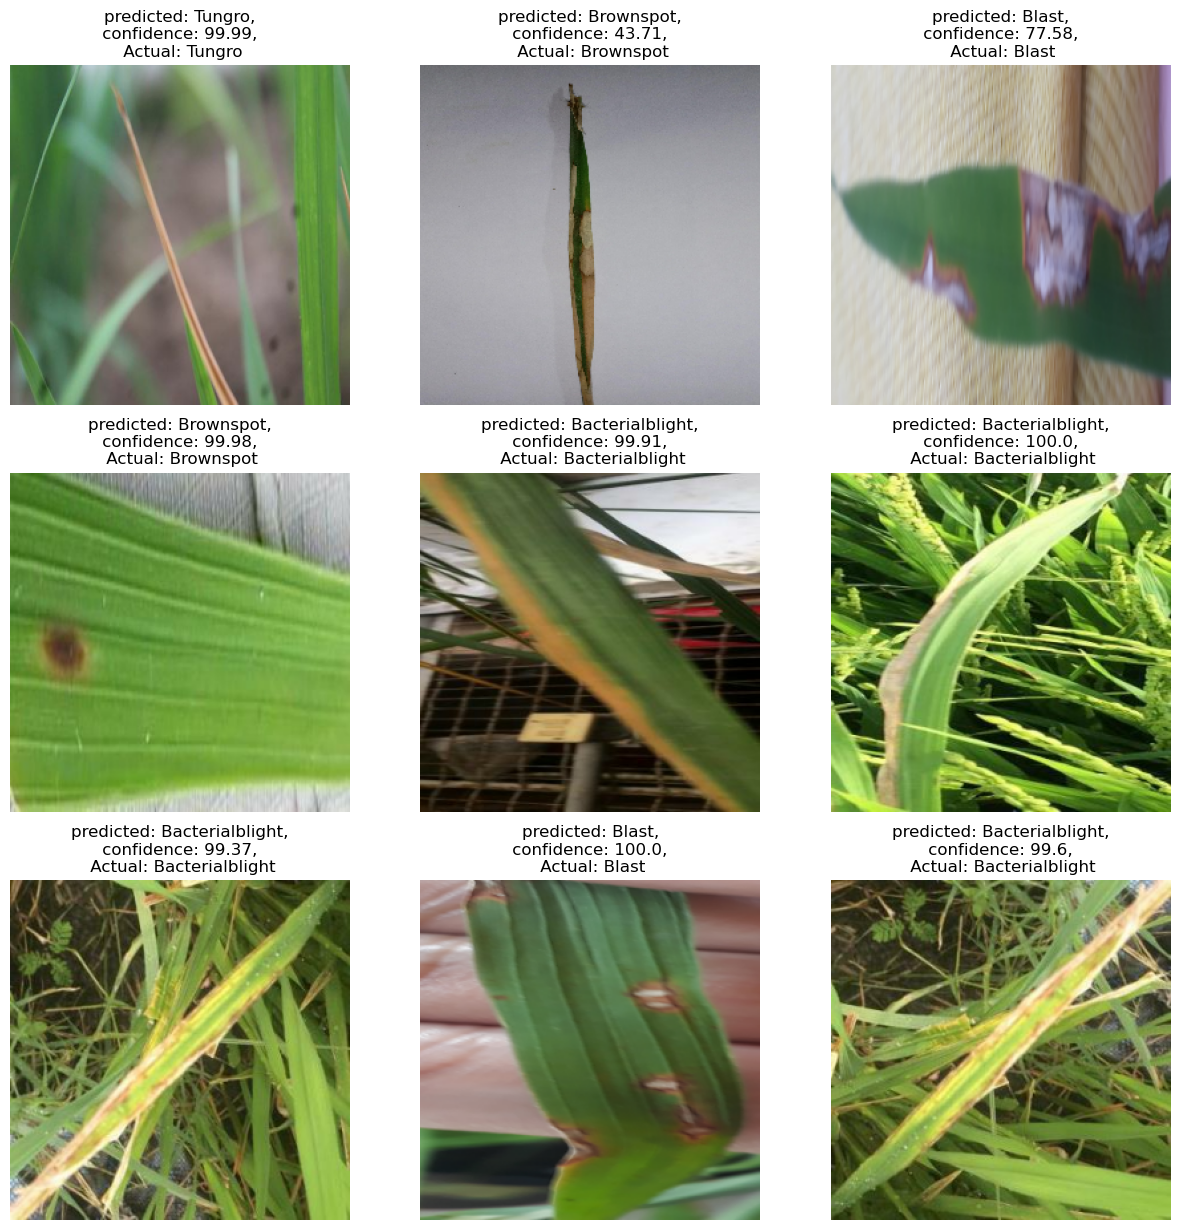

In [26]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f'predicted: {predicted_class},\n confidence: {confidence}, \n Actual: {actual_class}')
        plt.axis("off")

In [27]:
# Saving the model
model_version = max([int(i) for i in os.listdir("new_models") + [0]])+1
model.save(f'new_models\{model_version}')

INFO:tensorflow:Assets written to: new_models\2\assets


INFO:tensorflow:Assets written to: new_models\2\assets


In [60]:
new_model = tf.keras.models.load_model('new_models/2')

# Check its architecture
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [61]:
scores = new_model.evaluate(test_ds)
scores

26/26 [==============================] - 243s 1s/step - loss: 0.1314 - accuracy: 0.9543


[0.13144931197166443, 0.9543269276618958]

In [62]:
print("Accuracy : {:.3f}".format(scores[1]))

Accuracy : 0.954


New Image Prediction

In [63]:
import cv2
import numpy as np

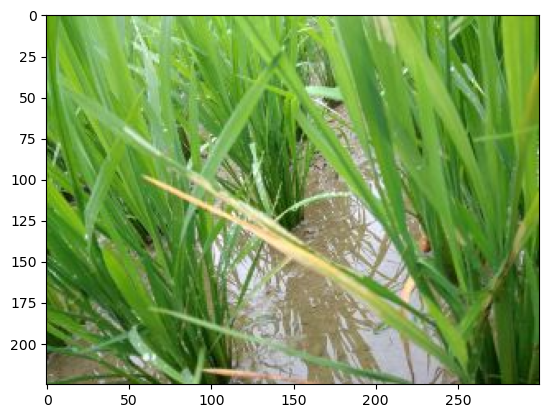

In [92]:
img_path = cv2.imread(os.path.join('rice_leaf_disease_images','Tungro','TUNGRO1_020.jpg'))
#img_path = cv2.imread(os.path.join('Testing images','bb1.jpg'))
img_path = cv2.cvtColor(img_path,cv2.COLOR_BGR2RGB)
plt.imshow(img_path)

In [93]:
img = cv2.resize(img_path,(256,256))
img = np.reshape(img,[1,256,256,3])

In [94]:
pred = new_model.predict(img)

1/1 [==============================] - 0s 105ms/step


In [95]:
pred

array([[2.4744952e-07, 2.6614054e-05, 1.1063103e-07, 1.4974265e-10,
        9.9997306e-01]], dtype=float32)

In [96]:
prediction_class = class_names[np.argmax(pred)]
prediction_class

'Tungro'

In [ ]:
#Confusion Matrix

In [69]:
from sklearn.metrics import confusion_matrix , classification_report

26/26 [==============================] - 22s 802ms/step


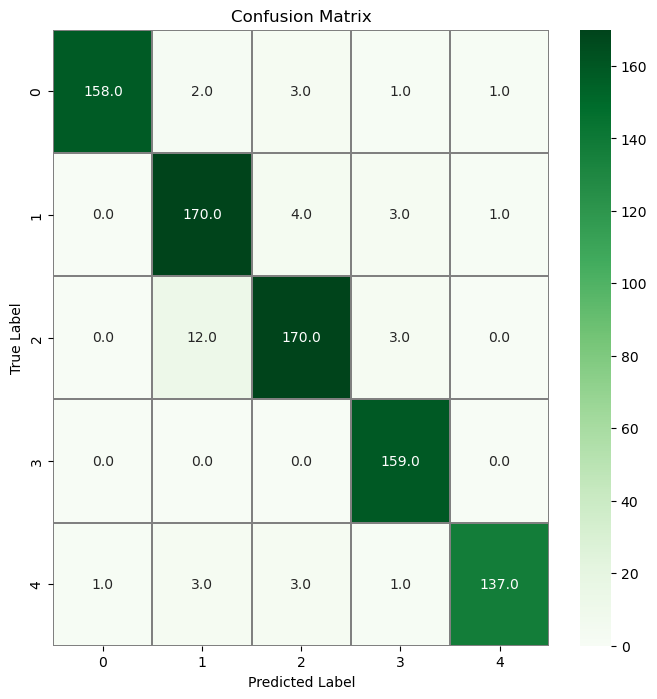

In [70]:
# confusion matrix
import seaborn as sns
# Predict the values from the validation dataset
Y_pred = new_model.predict(test_ds)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = tf.concat([y for x, y in test_ds], axis=0)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [71]:
print(classification_report(Y_true, Y_pred_classes, target_names=class_names))

                 precision    recall  f1-score   support

Bacterialblight       0.99      0.96      0.98       165
          Blast       0.91      0.96      0.93       178
      Brownspot       0.94      0.92      0.93       185
        Healthy       0.95      1.00      0.98       159
         Tungro       0.99      0.94      0.96       145

       accuracy                           0.95       832
      macro avg       0.96      0.96      0.96       832
   weighted avg       0.96      0.95      0.95       832

